In [40]:
import pandas as pd

In [41]:
from dateutil import parser as dateparser # doc https://dateutil.readthedocs.io/en/stable/parser.html
from dateutil.parser import parserinfo as dateparser_info
import plotly

In [42]:
# Input
column_of_interest = "Open"
date_column = 'Date'

# Setting
date_parser_info = dateparser_info()
date_parser_info._year = 1999

In [43]:
d = dateparser.parse("12/08/54 9:00:01", parserinfo=date_parser_info, dayfirst = True)

In [44]:
df = pd.read_csv('dataset/Google_Stock_Price_Train.csv')

In [45]:
df.head(2)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"


In [46]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [47]:
df['parsed_date'] = df.apply(lambda row: dateparser.parse(row['Date'], parserinfo=date_parser_info, dayfirst = False),axis = 1)

In [48]:
for c in df.columns:
    print(c, df[c].dtype)

Date object
Open float64
High float64
Low float64
Close object
Volume object
parsed_date datetime64[ns]


In [49]:
df.shape

(1258, 7)

In [50]:
df.head()

,Date,Open,High,Low,Close,Volume,parsed_date
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500",2012-01-03
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400",2012-01-04
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300",2012-01-05
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900",2012-01-06
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800",2012-01-09


In [51]:
df.set_index('Date',inplace = True)

In [52]:
df.head()

,Open,High,Low,Close,Volume,parsed_date
Date,,,,,,
1/3/2012,325.25,332.83,324.97,663.59,"7,380,500",2012-01-03
1/4/2012,331.27,333.87,329.08,666.45,"5,749,400",2012-01-04
1/5/2012,329.83,330.75,326.89,657.21,"6,590,300",2012-01-05
1/6/2012,328.34,328.77,323.68,648.24,"5,405,900",2012-01-06
1/9/2012,322.04,322.29,309.46,620.76,"11,688,800",2012-01-09


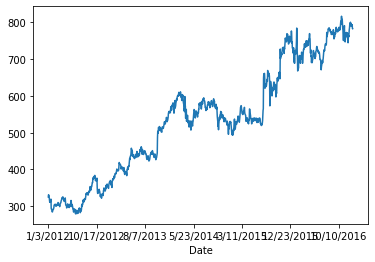

In [53]:
df[df]['Open'].astype(float).plot()

In [54]:
df.reset_index(inplace = True)

### Date parsing

In [55]:
def timestamp_processing(df,timestamp_column, list_granularity = ['year','month','weekday','hour','minute']):
    df[timestamp_column] = df.apply(lambda row: dateparser.parse(row[timestamp_column], parserinfo=date_parser_info, dayfirst = False),axis = 1)
    df['date_only'] = df[timestamp_column].apply(lambda row: row.date())
    
    # Creating column to isolate specific timestamps
    if "year" in list_granularity: 
        df['year'] = df[timestamp_column].apply(lambda row: row.year)
    if "month" in list_granularity: 
        df['month'] = df[timestamp_column].apply(lambda row: row.month)
    if "weekday" in list_granularity: 
        df['weekday'] = df[timestamp_column].apply(lambda row: row.weekday())
        df['weekend'] = 0
        df.loc[df.weekday > 4, 'weekend'] = 1
    if "hour" in list_granularity: 
        df['hour'] = df[timestamp_column].apply(lambda row: row.hour)
    if "minute" in list_granularity:
        df['minute'] = df[timestamp_column].apply(lambda row: row.minute)
    return df

In [56]:
df = timestamp_processing(df,'Date')

In [57]:
df.head()

,Date,Open,High,Low,Close,Volume,parsed_date,date_only,year,month,weekday,weekend,hour,minute
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500",2012-01-03,2012-01-03,2012,1,1,0,0,0
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400",2012-01-04,2012-01-04,2012,1,2,0,0,0
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300",2012-01-05,2012-01-05,2012,1,3,0,0,0
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900",2012-01-06,2012-01-06,2012,1,4,0,0,0
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800",2012-01-09,2012-01-09,2012,1,0,0,0,0


jan feb mar apr may jun jul aug sep oct nov dec

### Granularity

In [130]:
min_threshold_dic = {'month':{'threshold':3,'max':12},'weekday':{'threshold':5,'max':7},'hour':{'threshold':6,'max':24},'minute':{'threshold':30,'max':60}}

In [131]:
def identify_ideal_granularity_visualisation(df, min_threshold_dic):
    list_granularity_option = ['year','month','weekday','hour']# ,'seconds','other',
    scales = {}
    
    def _check_nbr_consecutive_elements(nbr_consecutive_elements, scale, scales):
        if nbr_consecutive_elements >= min_threshold_dic[scale]['threshold']:
            
            ratio = float(nbr_consecutive_elements/min_threshold_dic[scale]['max'])
            scales[scale] = {'consecutive_nbr':nbr_consecutive_elements, 'ratio':ratio}
        return scales 
    
    def _check_cycle_threshold(df, element, scales):
        list_unique_elements = sorted(df[element].unique())
        nbr_consecutive_elements = 0

        for element_value in list_unique_elements:
              # Doesn't handle the case where we have 2020-01, 2020-02, 2020-03, 2020-12, will consider that 2020-12 is part of 2019, and therefore the months consecutive
            try: 
                # Checking that the two months are consecutive
                if element_value+1 == list_unique_elements[list_unique_elements.index(element_value)+1]:
                    nbr_consecutive_elements +=1
                # restarting the counter and keep searching for consecutive months
                else:
                    nbr_consecutive_elements = 0

            # Excluding last month that cause an out of range error
            except IndexError: 
                nbr_consecutive_elements +=1
            # Checking if at this point (not at the end of the list of unique month, days etc yet) we have enough consecutive element to validate this scale 
            scales = _check_nbr_consecutive_elements(nbr_consecutive_elements, element, scales)
        # if we managed to get to the end of the list of elements to check without issue, check that we have found enough to validate the scale
        scales = _check_nbr_consecutive_elements(nbr_consecutive_elements, element, scales)
        
        return scales
    
    for scale in list_granularity_option:
        # Check that there is a cycle (i.e. minimum of two elements)
        if len(df[scale].unique()) > 2:
            # Check that at least threshold of the cycle is represented
            # except for Year that doesn't require a minimum threshold (12 months make a year cycle but no minimum number of year make a cycle - assuming we don't care about decades)
            if scale =='year':
                scales['year'] = {'consecutive_nbr':len(df[scale].unique()), 'ratio':1}
            
            elif scale == 'month':
                _check_cycle_threshold(df, scale, scales)
                
            elif scale == 'weekday':
                _check_cycle_threshold(df, scale, scales)
                
            elif scale == 'hour':
                _check_cycle_threshold(df, scale, scales)
            
            elif scale == 'minute':
                _check_cycle_threshold(df, scale, scales)
                            
    return scales

In [132]:
highest_scale = identify_ideal_granularity_visualisation(df, min_threshold_dic)

In [133]:
highest_scale

{'year': {'consecutive_nbr': 5, 'ratio': 1},
 'month': {'consecutive_nbr': 12, 'ratio': 1.0},
 'weekday': {'consecutive_nbr': 5, 'ratio': 0.7142857142857143}}

### Biggest Gains / Drop (by time level) 

- Biggest weekly growth
- biggest monthly growth 
- biggest yearly growth

In [63]:
df.set_index(date_column,inplace = True)

### Biggest Growth / Decrease (regardless of the time)

In [90]:
df.head()

,Open,High,Low,Close,Volume,parsed_date,date_only,year,month,weekday,weekend,hour,minute
Date,,,,,,,,,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500",2012-01-03,2012-01-03,2012,1,1,0,0,0
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400",2012-01-04,2012-01-04,2012,1,2,0,0,0
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300",2012-01-05,2012-01-05,2012,1,3,0,0,0
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900",2012-01-06,2012-01-06,2012,1,4,0,0,0
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800",2012-01-09,2012-01-09,2012,1,0,0,0,0


In [296]:
def find_largest_decrease(df,column_of_interest,display_top_x_values = 10, rolling = 1):

    start = 0
    end = 0
    max_start = 0 
    max_end = 0
    diff_end_start_values = 0

    all_consecutive_decrease = {}
    
    rol_mean = df[column_of_interest].astype(float).rolling(rolling).mean()
    col = [value for value in list(rol_mean) if str(value) != 'nan']
    rol_mean.plot()

    for i in range(0,len(col)-1):

        if col[i] > col[i+1]:
            end = i+1
            
        else:
            diff_start_end_values = col[start] - col[end]
            all_consecutive_decrease[(start,end)] = diff_start_end_values
            start = i+1 
            end = i+1
            
    return sorted(all_consecutive_decrease.items(), key=lambda x: x[1], reverse=True)[:display_top_x_values]

[((528, 571), 72.03633333333357),
 ((660, 699), 40.292333333333204),
 ((173, 203), 31.129333333333363),
 ((1053, 1083), 29.343999999999937),
 ((706, 738), 27.623999999999796),
 ((44, 104), 27.608999999999867),
 ((998, 1015), 26.681333333333555),
 ((978, 995), 20.96766666666656),
 ((1194, 1216), 17.806333333333555),
 ((903, 915), 13.89133333333325)]

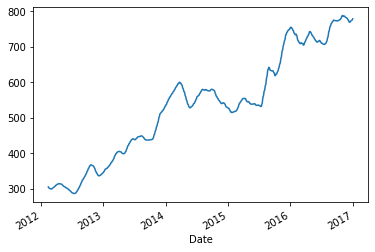

In [299]:
top_10 = find_largest_decrease(df,column_of_interest,rolling = 30) # TO DO - set the rolling systematically
top_10

In [294]:
def find_largest_growth(df,column_of_interest,display_top_x_values = 10, rolling = 1):
    
    start = 0
    end = 0
    max_start = 0 
    max_end = 0
    diff_end_start_values = 0
    
    all_consecutive_increase = {}
    
    rol_mean = df[column_of_interest].astype(float).rolling(rolling).mean()
    col = [value for value in list(rol_mean) if str(value) != 'nan']
    rol_mean.plot()
    
    for i in range(0,len(col)-1):

        if col[i] < col[i+1]:
            end = i+1

        else:
            diff_end_start_values = col[end] - col[start]
            all_consecutive_increase[(start,end)] = diff_end_start_values
            start = i+1 
            end = i+1
    
    return sorted(all_consecutive_increase.items(), key=lambda x: x[1], reverse=True)[:display_top_x_values]

[((874, 889), 115.25166666666655),
 ((933, 958), 98.99666666666667),
 ((1123, 1156), 91.136666666667),
 ((121, 184), 89.66749999999985),
 ((436, 455), 76.64916666666659),
 ((463, 506), 63.21916666666681),
 ((314, 340), 53.35833333333346),
 ((252, 292), 48.92083333333318),
 ((959, 979), 38.73583333333386),
 ((606, 635), 37.539166666666574),
 ((1040, 1058), 36.504166666666606),
 ((770, 792), 36.44999999999993),
 ((515, 537), 34.79166666666674),
 ((215, 250), 34.42750000000001),
 ((586, 602), 34.10000000000002),
 ((1230, 1244), 30.853333333333353),
 ((756, 768), 21.90999999999991),
 ((1085, 1105), 20.84916666666686),
 ((894, 903), 19.837499999999977),
 ((1011, 1018), 18.90750000000014)]

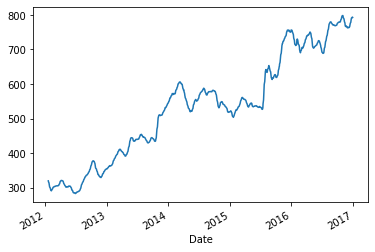

In [295]:
top_11 = find_largest_growth(df,column_of_interest,display_top_x_values=20, rolling = 12) # TO DO - set the rolling systematically
top_11

### Moving average

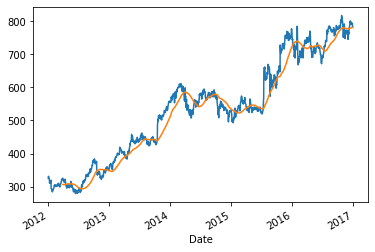

In [300]:
df[column_of_interest].astype(float).rolling(1).mean().plot()
df[column_of_interest].astype(float).rolling(60).mean().plot()

else:
            if col[end] - col[start] > diff_end_start_values:
                max_start = start
                max_end = end
                diff_end_start_values = col[end] - col[start]
                all_consecutive_increase[(max_start,max_end)] = diff_end_start_values
                start = i+1 
                end = i+1
                diff_end_start_values = 0


- Date parser # DONE
- Granularity figure out [seconds, minutes, hours, days, months, year] Whenever two consecutive are provided and start by the highest, knowning that at least 30% of a full unit (i.e. 4 months, 2 weeks, 3 days , 8 hours) must be provided to select the granularity level. # DONE

- Then, select the next level as a measure / groupby.

- biggest drop, Gains, for the 2nd highest scale possible

- Find date column
- Handle convertion of number string column to int and float example '1,999.9' to float(1999.9)
- Work on how to detect Column of interest / of measurement
- Biggest growth, decrease, normalized by the size
- most predictable lags by the ACF
- Fit a regression, the r2 (explained variance) the fewest # of params
- rolling averages
- reset_index systematically
...